# Precursor Charge State Prediction

This notebook presents a short walkthrough the process of reading a dataset and training a model for precursor charge state prediction. The dataset is an example dataset extracted from a ProteomTools dataset generated in the **Chair of Bioanalytics** at the **School of Life Sciences** at the **Technical University of Munich**.

DLOmix is the framework being used here and it is a custom wrapper on top of Keras/TensorFlow and PyTorch.
This walkthrough focusses on TensorFlow.

In [1]:
%env DLOMIX_BACKEND tensorflow

import dlomix
#dlomix.__version__

env: DLOMIX_BACKEND=tensorflow
Using TensorFlow Backend for DLOmix. To change the backend, set the DLOMIX_BACKEND environment variable to tensorflow or pytorch and re-import DLOmix.


2025-04-15 09:10:15.650979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 09:10:15.651022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 09:10:15.652676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 09:10:15.660779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 09:10:17.372237: W tensorflow/compiler/tf2

The available modules in the framework are as follows:

- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around HuggingFace datasets to process input data and generate tensor datasets
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations for Retention Time Prediction
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

In [2]:
from dlomix import constants, data, eval, layers, models, pipelines, reports
print([x for x in dir(dlomix) if not x.startswith("_")])

/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications

['BACKEND_IMPORT_ERROR_MESSAGE', 'BACKEND_PRETTY_NAME', 'PYTORCH_BACKEND', 'TENSORFLOW_BACKEND', 'config', 'constants', 'data', 'eval', 'layers', 'losses', 'models', 'pipelines', 'reports', 'tensorflow']


## required imports

In [13]:
import tensorflow as tf

import matplotlib.pyplot as plt

from dlomix.constants import PTMS_ALPHABET
from dlomix.data import ChargeStateDataset
from dlomix.eval import adjusted_mean_absolute_error
from dlomix.models import ChargeStatePredictor

## 1. Load Data

We can import the dataset class and create an object of type `ChargeStateDataset`. This object wraps around a Hugging Face dataset that can generate TensorFlow Dataset objects or Torch Dataset for training, validation, or testing. This can be controlled by the arguments `val_ratio`, `val_data_source`, and `test_data_source`.

The most important columns of the charge state dataset are:
* "modified_sequence", representing the peptide sequences, modifications are annotated using the UNIMOD encoding.
* "charge_state_dist", representing the relative charge state distribution per peptide. It is to be used together with the model_flavour="relative", which is the default.
* "most_abundant_charge_state", representing the most abundant charge state (as binary vector) per peptide. It is to be used together with the model_flavour="dominant".
* "observed_charge_states", representing all observed charge states (as binary vector) per peptide. It is to be used together with the model_flavour="observed".

In [6]:
DATA_PATH = "Wilhelmlab/prospect-ptms-charge"   # complete PROSPECT dataset prepared for charge state prediction
BATCH_SIZE = 2048

In [7]:
d = ChargeStateDataset(
    data_format="hub",
    data_source=DATA_PATH,
    sequence_column="modified_sequence",
    label_column="charge_state_dist",   # use this column for relative charge state distribution
    max_seq_len=30,
    batch_size=BATCH_SIZE,
)

Applying step: SequenceParsingProcessor on split train...
Applying step: SequenceParsingProcessor on split val...


Mapping SequenceParsingProcessor: 100%|██████████| 328072/328072 [00:05<00:00, 58227.29 examples/s]


Applying step: SequenceParsingProcessor on split test...


Mapping SequenceParsingProcessor: 100%|██████████| 161588/161588 [00:02<00:00, 53940.07 examples/s]


Applying step: SequencePTMRemovalProcessor on split train...


Mapping SequencePTMRemovalProcessor: 100%|██████████| 1142537/1142537 [00:34<00:00, 32864.85 examples/s]


Applying step: SequencePTMRemovalProcessor on split val...


Mapping SequencePTMRemovalProcessor: 100%|██████████| 328072/328072 [00:10<00:00, 31561.55 examples/s]


Applying step: SequencePTMRemovalProcessor on split test...


Mapping SequencePTMRemovalProcessor: 100%|██████████| 161588/161588 [00:05<00:00, 31391.55 examples/s]


Applying step: SequenceEncodingProcessor on split train...


Mapping SequenceEncodingProcessor: 100%|██████████| 1142537/1142537 [00:34<00:00, 32720.37 examples/s]


Applying step: SequenceEncodingProcessor on split val...


Mapping SequenceEncodingProcessor: 100%|██████████| 328072/328072 [00:10<00:00, 31203.81 examples/s]


Applying step: SequenceEncodingProcessor on split test...


Mapping SequenceEncodingProcessor: 100%|██████████| 161588/161588 [00:05<00:00, 30594.48 examples/s]


Applying step: SequencePaddingProcessor on split train...


Filter: 100%|██████████| 1142537/1142537 [00:02<00:00, 523438.04 examples/s]


Applying step: SequencePaddingProcessor on split val...


Filter: 100%|██████████| 328072/328072 [00:00<00:00, 433943.42 examples/s]


Applying step: SequencePaddingProcessor on split test...


Mapping SequencePaddingProcessor: 100%|██████████| 161588/161588 [00:04<00:00, 37225.80 examples/s]


Now we have an CS dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.tensor_train_data` and `.tensor_val_data`.

In [8]:
print("Hugging Face Dataset:", d)

print("Training examples:", len(d["train"]))
print("one training batch looks like:")
for x in d.tensor_train_data:
    print(x)
    break

print("Validation examples:", len(d["val"]))

Hugging Face Dataset: DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 1138142
    })
    val: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 326769
    })
    test: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 161588
    })
})
Training examples: 1138142
one training batch looks like:


/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
2025-04-15 09:20:58.557133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5596 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
2025-04-15 09:20:58.557805: I tensorflow/core/common_runtime/gpu/gpu_devi

(<tf.Tensor: shape=(2048, 30), dtype=int64, numpy=
array([[21,  7,  2, ...,  0,  0,  0],
       [21, 16, 13, ...,  0,  0,  0],
       [21,  8, 10, ...,  0,  0,  0],
       ...,
       [21, 11, 18, ...,  0,  0,  0],
       [21, 10, 12, ...,  0,  0,  0],
       [21, 17,  4, ...,  0,  0,  0]])>, <tf.Tensor: shape=(2048, 6), dtype=float32, numpy=
array([[0.        , 0.27535924, 0.7246407 , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ]], dtype=float32)>)
Validation examples: 326769


2025-04-15 09:20:59.098355: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: AttributeError: 'Dataset' object has no attribute '_data'
Traceback (most recent call last):

  File "/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf_mini_AyS/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/cmnfs/home/a.schroeder/miniconda3/envs/dlomix_tf

## 2. Model

We can now create the model. We will use the relative charge state distribution version (set via the parameter model_flavour="relative") of the Prosit-based Precursor Charge State Prediction model `ChargeStatePredictor`. It has default working arguments, but most of the parameters can be customized.

**Note**: Important is to ensure that the padding length used for the dataset object is equal to the sequence length passed to the model.

The three model flavours of `ChargeStatePredictor` are:

1. Dominant Charge State Prediction:
   - Task: Predict the dominant charge state of a given peptide sequence.
   - Model: Uses a deep learning model (RNN-based) inspired by Prosit's architecture to predict the most likely charge state.

2. Observed Charge State Prediction:
   - Task: Predict the observed charge states for a given peptide sequence.
   - Model: Uses a multi-label classification approach to predict all possible charge states.

3. Relative Charge State Prediction:
   - Task: Predict the proportion of each charge state for a given peptide sequence.
   - Model: Uses a regression approach to predict the proportion of each charge state.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [10]:
model = model = ChargeStatePredictor(
    num_classes=6, seq_length=30, alphabet=PTMS_ALPHABET, model_flavour="relative"
)

## 3. Training

We can then train the model like a standard Keras model. You can observe the decreasing loss value

In [11]:
model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=[adjusted_mean_absolute_error],
)

In [12]:
history = model.fit(
    d.tensor_train_data, 
    validation_data=d.tensor_val_data,
    epochs=1,  # reduced for demonstration
)

2025-04-15 09:21:21.558068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-15 09:21:23.485219: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f868e450f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-15 09:21:23.485270: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-04-15 09:21:23.485291: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-04-15 09:21:23.485310: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-04-15 09:21:23.531701: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744708883.760613 1220558 device

556/556 [==============================] - 165s 280ms/step - loss: 0.0488 - adjusted_mean_absolute_error: 0.1164 - val_loss: 0.0287 - val_adjusted_mean_absolute_error: 0.0682


### Visualize Training History

In [14]:
def plot_learning_curves(history, title='Learning Curves'):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

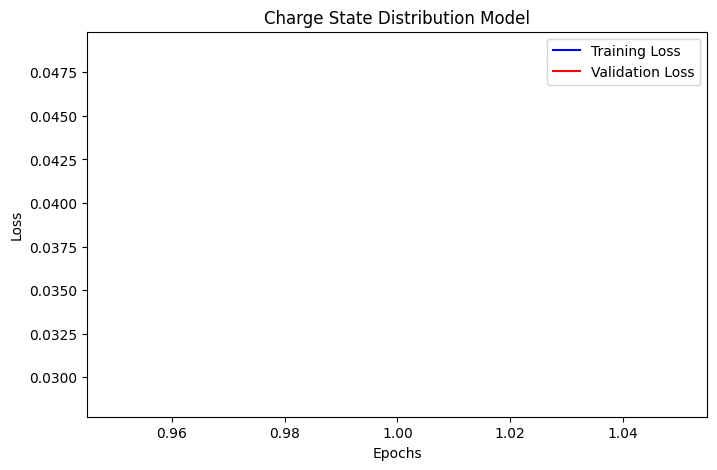

In [15]:
plot_learning_curves(history, title='Charge State Distribution Model')

## 3. Testing

The ChargeStateDataset also contains a test dataset to test our model.

**Note**: Currently there is no reporting module available for CS prediction.

In [16]:
test_targets = d["test"]["charge_state_dist"]
test_sequences = d["test"]["modified_sequence"]

In [17]:
predictions = model.predict(test_sequences)
print(test_sequences[:5])
print(test_targets[:5])
print(predictions[:5])
print(predictions.shape, len(test_targets))

5050/5050 [==============================] - 39s 7ms/step
[[21, 20, 8, 7, 12, 8, 10, 16, 8, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [21, 5, 7, 17, 13, 16, 12, 16, 20, 17, 1, 14, 15, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [21, 8, 13, 6, 13, 4, 6, 14, 4, 18, 10, 2, 9, 14, 8, 9, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [21, 17, 6, 14, 9, 18, 1, 10, 9, 9, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [21, 1, 17, 10, 2, 2, 1, 15, 13, 4, 13, 15, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.18388216654438674, 0.8161178334556133, 0.0, 0.0, 0.0], [0.0, 0.03440733446425485, 0.9655926655357452, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.007387597915967662, 0.9926124020840323, 0.0, 0.0, 0.0]]
[[ 1.6248247e-02  9.4760293e-01 -8.5926037e-03  5.4676011e-03
   2.7500184e-03 -9.5755327e-04]
 [-2.4547828e-03  2.9708153e-01  6.6442794e-01 -4.5503341e-03
   2.4660879e-03 -1.2378106e-0

## 4. Saving and Loading Models

Models can be saved normally the same Keras models would be saved. It is better to save the weights and the not the model since it makes it easier and more platform-indepdent when loading the model again. The extra step needed is to create a model object and then load the weights.

In [18]:
# save the model weights

save_path = "./output/csd_model"
model.save_weights(save_path)

In [19]:
# models can be later loaded by creating a model object and then loading the weights

trained_model = ChargeStatePredictor(seq_length=32)
trained_model.load_weights(save_path)